### Neural Network - HW7
#### Conditional GAN
#### Majid Adibian - 400131078

#### install packages

In [ ]:
%pip install imageio
%pip install torchviz

#### import libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd

from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import make_grid, save_image

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Preprocess data

In [4]:
### Get data and normalize any images by transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
data = MNIST('data', train=True, download=True, transform=transform)
print(data)
batch_size = 128
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


### CGAN

#### create models

In [5]:
class Discriminator(nn.Module):
    def __init__(self, data_shape):
        super().__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.linear1 = nn.Linear(data_shape[1]*data_shape[2]+10, 1024)
        self.activation1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(1024, 512)
        self.activation2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(512, 256)
        self.activation3 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout3 = nn.Dropout(0.2)
        self.linear4 = nn.Linear(256, 1)
        self.activation4 = nn.Sigmoid()
    
    def forward(self, inputs, labels):
        inputs = inputs.squeeze()
        inputs = inputs.view(inputs.size(0), inputs.size(1)*inputs.size(2))
        labels = self.label_embedding(labels)
        x = torch.cat([inputs, labels], 1)
        x = self.dropout1(self.activation1(self.linear1(x)))
        x = self.dropout2(self.activation2(self.linear2(x)))
        x = self.dropout3(self.activation3(self.linear3(x)))
        out = self.activation4(self.linear4(x)).squeeze()
        return out

# class Discriminator(nn.Module):
#     def __init__(self, data_shape):
#         super().__init__()
#         self.label_embedding = nn.Embedding(10, 10)
#         self.linear0 = nn.Linear(10, 784)
#         self.conv1 = nn.Conv2d(2, 16, 5, padding=2)
#         self.BN1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
#         self.BN2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
#         self.BN3 = nn.BatchNorm2d(64)
#         self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
#         self.activation1 = nn.LeakyReLU(0.2, inplace=True)
#         self.linear1 = nn.Linear(1024, 128)
#         self.linear2 = nn.Linear(128, 1)
#         self.activation2 = nn.Sigmoid()

#     def forward(self, inputs, labels):
#         # type(inputs)
#         if len(inputs.shape) == 3:
#             inputs = torch.unsqueeze(inputs, 1)
#         labels = self.label_embedding(labels)
#         labels = self.linear0(labels)
#         labels = labels.view(labels.size(0), inputs.size(2), inputs.size(2)).unsqueeze(1)
#         x = torch.cat([inputs, labels], 1)
#         x = self.pool1(self.activation1(self.BN1(self.conv1(x))))
#         x = self.pool1(self.activation1(self.BN2(self.conv2(x))))
#         x = self.pool1(self.activation1(self.BN3(self.conv3(x))))
#         x = torch.flatten(x, 1)
#         x = self.activation1(self.linear1(x))
#         out = self.activation2(self.linear2(x)).squeeze()
#         return out
        
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.linear1 = nn.Linear(110, 256)
        self.activation1 = nn.LeakyReLU(0.2, inplace=True)
        self.linear2 = nn.Linear(256, 512)
        self.activation2 = nn.LeakyReLU(0.2, inplace=True)
        self.linear3 = nn.Linear(512, 1024)
        self.activation3 = nn.LeakyReLU(0.2, inplace=True)
        self.linear4 = nn.Linear(1024, 784)
        self.activation4 = nn.Tanh()
    
    def forward(self, input_noise, labels):
        input_noise = input_noise.view(input_noise.size(0), input_noise.size(1))
        labels = self.label_embedding(labels)
        x = torch.cat([input_noise, labels], 1)
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        out = self.activation4(self.linear4(x)).view(x.size(0), 28, 28)
        return out

#### Train models

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'using {device}')

using cuda


In [7]:
criterion = nn.BCELoss()
generator = Generator()
discriminator = Discriminator(next(iter(data_loader))[0][0].shape)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
generator.to(device)
discriminator.to(device)
print("models are ready..")

models are ready..


In [8]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, torch.ones(batch_size).to(device)).to(device)
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size).to(device)).to(device)
    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [9]:
num_epochs = 60
num_discriminator_train = 5
all_g_loss, all_d_loss = [], []
all_image_per_epoch = []
for epoch in range(num_epochs):
    train_bar = tqdm(data_loader, leave=True)
    local_g_loss, local_d_loss = [], []
    for step, data in enumerate(train_bar):
        images, labels = data
        real_images = images.to(device)
        labels = labels.to(device)
        generator.train()
        d_loss = 0
        for _ in range(num_discriminator_train):
            d_loss = discriminator_train_step(len(real_images), discriminator, generator, d_optimizer, criterion, real_images, labels)
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        local_g_loss.append(g_loss)
        local_d_loss.append(d_loss)
        if step%30 == 0:
            g_loss = sum(local_g_loss)/len(local_g_loss)
            d_loss = sum(local_d_loss)/len(local_d_loss)
            all_g_loss.append(g_loss)
            all_d_loss.append(d_loss)
            train_bar.set_description(f'epoch {epoch}')
            train_bar.set_postfix({'g_loss': g_loss, 'd_loss': d_loss})
            local_g_loss = []
            local_d_loss = []
        if step == len(data_loader)-1:
            generator.eval()
            z = torch.randn(100, 100).to(device)
            labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)
            sample_images = generator(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=10, normalize=True)
            save_image(grid, f'images/epoch{epoch}.png')
            all_image_per_epoch.append(grid)

epoch 59: 100%|██████████| 469/469 [00:40<00:00, 11.52it/s, g_loss=1.88, d_loss=0.764]


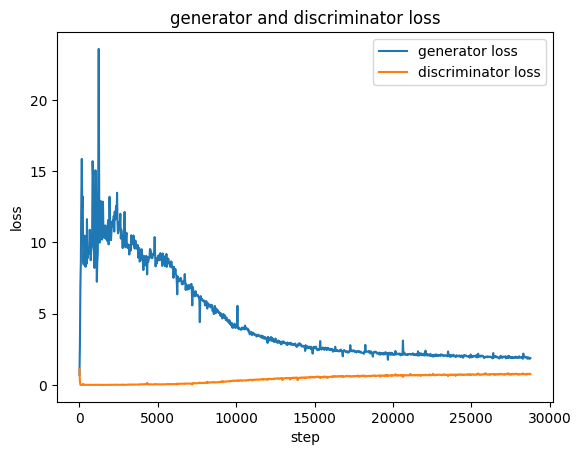

In [10]:
### Show loss changes
plt.plot(np.arange(0,len(all_g_loss))*30, all_g_loss, label='generator loss')
plt.plot(np.arange(0,len(all_g_loss))*30, all_d_loss, label='discriminator loss')
plt.title("generator and discriminator loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.show()

In [11]:
### Save models
torch.save(generator.state_dict(), 'models/generator_state.pt')
torch.save(discriminator.state_dict(), 'models/discriminator_state.pt')

#### Generate a gif for results changes

In [21]:
import imageio

with imageio.get_writer('images/changes.gif', mode='I') as writer:
    for filename in [f'images/epoch{i}.png' for i in range(60)]:
        image = imageio.imread(filename)
        writer.append_data(image)
        writer.append_data(image)

/tmp/ipykernel_1917758/619668610.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
